# CNN 이용하여 MINST 분류하기
+ 본과정에서는 CNN(Convolution Neuron Network) 이용해서 손글씨 MNIST를 분류하는 실습 수행합니다.
+ 입력은 Keras Datasets MNIST 활용하며
+ CNN 모델 구성하고 CNN layer 접근 및 가중치 확인해 보겠숩니다.
+ 또한, FCNN 모델보다 CNN이 더 좋은 성능을 내는지 확인해 보겠습니다.

### 학습목차
1. Import modules
2. 데이터 불러오기 : Keras Dataset MNIST 활용
3. CNN 모델 구성
4. 모델 Compile : model.compile
5. 학습 수행 : model.fit , EarlyStopping , ModelCheckpoint
6. 학습 결과 테스트 : model.evaluate
7. 성능 그래프
8. 설젠 테스트 : 손글씨 입력해서 분류 잘하는지 보기

## 1. Import modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. 데이터 불러오기

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
# 3차원 배열
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
y_train.shape, y_test.shape

((60000,), (10000,))

## 3. CNN 모델 구성

#### <font color=blue>ㅇ CNN 입력 구조 : 4차원 : Batch * Height * Weidth * Channel</font>

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [7]:
# 28 X 28 shape를 CNN 모델에 입력으로 주기 위해 28 X 28 X 1 shape 변경 : 채널 추가

# x_train = x_train.reshape(x_train.shape[0], 28, 28 ,1)
# x_test = x_test.reshape(x_test.shape[0], 28, 28 ,1)

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same',
                 activation='relu',
                 input_shape=(28,28,1)))  # 28 X 28 X 32
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))  # 14 X 14 X 32
model.add(Conv2D(64,(2,2), activation='relu', padding='same'))  # 14 X 14 X 64
model.add(MaxPooling2D(pool_size=(2,2)))  # 7 X 7 X 64
model.add(Dropout(0.2))
model.add(Flatten())  # 3136
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

### <font color=blue>ㅇ 모델 각 레이어 접근</font>
- 전이학습 사용할때 모델의 필요한 부분을 가져와야 하므로
- 모델의 각 레이어 접근할수 있어야 함.

In [13]:
# 모델 입력
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [14]:
# 모델 출력
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_1')>

In [16]:
# 모델 레이어들 : 리스트 구성
model.layers

In [17]:
# 모델 첫번쩨 레이어 Conv2D
model.layers[0]

In [18]:
# 모델 첫번쩨 레이어 Conv2D의 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [19]:
# 모델 첫번쩨 레이어 Conv2D의 출력 : 32개 필터 출력
model.layers[0].output

<KerasTensor: shape=(None, 28, 28, 32) dtype=float32 (created by layer 'conv2d')>

In [20]:
# 모델 첫번쩨 레이어 Conv2D의 커널 가중치 계산
# 1) shape=(5, 5, 1, 32) 의미 : 5 X 5 커널에 대해 input 채널 1개 , output 채널 32개(FeatureMap) --> 5 X 5 X 1 X 32 크기의 파라미터
# 2) shape=(32,) 의미 : 32개 출력 bias 파라미터
# 첫번째 Conv2D 레이어는 800 + 32 = 832 파라미터 생성

model.layers[0].weights

[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 32) dtype=float32, numpy=
 array([[[[ 1.49704516e-04, -6.05862960e-02,  4.99435663e-02,
           -7.56818056e-02, -6.04861379e-02,  3.44404578e-03,
            1.61204487e-02,  7.01463521e-02,  2.01871321e-02,
            5.98928183e-02, -1.74498409e-02,  3.66172343e-02,
           -8.22675526e-02,  3.89403179e-02,  5.58570325e-02,
           -6.81683719e-02, -5.22432998e-02, -7.55267665e-02,
           -5.18009886e-02,  6.56472296e-02, -6.72696158e-02,
            6.03984445e-02, -7.96539187e-02, -7.60899559e-02,
            1.81738734e-02,  7.62795508e-02,  4.45080251e-02,
           -4.82421480e-02, -1.96240619e-02, -5.83448485e-02,
           -6.46548495e-02, -4.07091528e-03]],
 
         [[ 5.33741415e-02,  1.46193802e-03,  5.18598408e-03,
            5.21727651e-02, -2.96458043e-02, -6.24707825e-02,
           -4.80012670e-02, -5.42761385e-03, -1.79364756e-02,
           -6.92872033e-02,  2.26669759e-03,  8.92771780e-03,
         

In [21]:
# 다시 한번 model layout 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [22]:
# 'conv2d_1' 이름으로 레이어 접근하기. 이름이 다를수 있으니 주의해서 입력
model.get_layer('conv2d_1')

In [23]:
#'conv2d_1' 이름 레이어 입력
model.get_layer('conv2d_1').input

<KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'max_pooling2d')>

In [24]:
#'conv2d_1' 이름 레이어 출력
model.get_layer('conv2d_1').output

<KerasTensor: shape=(None, 14, 14, 64) dtype=float32 (created by layer 'conv2d_1')>

## 5. 모델 Compile

In [25]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [26]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [27]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## 6. 학습 수행

In [28]:
EPOCHS = 5
BATCH_SIZE = 1024

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
es = EarlyStopping(monitor='val_loss', patience=4, mode='min', verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [31]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es, mc], validation_data=(x_test, y_test))

Epoch 1/5
59/59 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.7818
Epoch 1: val_accuracy improved from -inf to 0.94220, saving model to best_model.h5
59/59 [==============================] - 14s 37ms/step - loss: 0.7098 - accuracy: 0.7818 - val_loss: 0.1940 - val_accuracy: 0.9422
Epoch 2/5
 4/59 [=>............................] - ETA: 1s - loss: 0.2640 - accuracy: 0.9155

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/59 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.9436
Epoch 2: val_accuracy improved from 0.94220 to 0.97330, saving model to best_model.h5
59/59 [==============================] - 1s 25ms/step - loss: 0.1858 - accuracy: 0.9438 - val_loss: 0.0904 - val_accuracy: 0.9733
Epoch 3/5
57/59 [===========================>..] - ETA: 0s - loss: 0.1119 - accuracy: 0.9673
Epoch 3: val_accuracy improved from 0.97330 to 0.98230, saving model to best_model.h5
59/59 [==============================] - 1s 25ms/step - loss: 0.1116 - accuracy: 0.9673 - val_loss: 0.0576 - val_accuracy: 0.9823
Epoch 4/5
58/59 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9742
Epoch 4: val_accuracy improved from 0.98230 to 0.98440, saving model to best_model.h5
59/59 [==============================] - 1s 25ms/step - loss: 0.0865 - accuracy: 0.9742 - val_loss: 0.0478 - val_accuracy: 0.9844
Epoch 5/5
58/59 [============================>.] - ETA: 0s - loss: 0.0722 - accurac

## 7. 학습 결과 테스트

In [32]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0420 - accuracy: 0.9861


[0.04200964793562889, 0.9861000180244446]

## 8. 성능 그래프

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
x_range = range(1,len(history.history['accuracy'])+1)

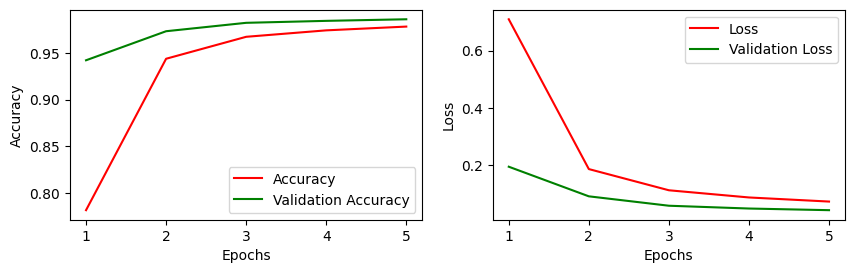

In [35]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(x_range, history.history['accuracy'], color='red', label='Accuracy')
plt.plot(x_range, history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(222)
plt.plot(x_range, history.history['loss'], color='red', label='Loss')
plt.plot(x_range, history.history['val_loss'], color='green', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 9. 실전 테스트

In [36]:
# 3차원 이미지
x_test[0].shape

(28, 28, 1)

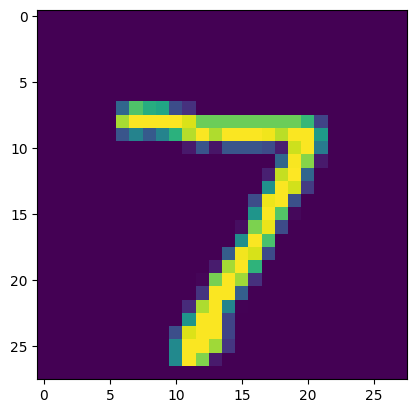

1/1 [==============================] - 0s 120ms/step
Prediction Probability:  [[2.5047868e-07 1.1882207e-07 7.7294339e-07 2.5602044e-06 1.2131205e-08
  2.0312023e-09 3.2132097e-10 9.9999523e-01 2.5398590e-08 1.0053327e-06]]
The Answer is  [7]


In [37]:
n = 0
plt.imshow(x_test[n].reshape(28,28))
plt.show()

pred = model.predict(x_test[n].reshape(1,28,28,1))
answer = np.argmax(pred, axis=-1)

print('Prediction Probability: ', pred)
print('The Answer is ', answer)

## 배운 내용 정리
1. Keras 손글씨 MNIST Dataset 활용
2. CNN 모델 구성 : 이전 실습 FCNN 보다는 약간의 성능 향상 있었음.(FCNN :0.97, CNN : 0.98)
3. CNN 모델의 layer 접근해 보고 가중치 계산 수행
4. FCNN 모델 보다 CNN 모델이 성능이 좀더 우수한걸 확인해 보았습니다.
5. FCNN 모델 경우, 이미지를 Flatten해서 1차원을 만들어 위치 정보를 잃어 버리고
6. 이미지 사이즈가 커지고 복잡해 진다면 FCNN 보다는 CNN 성능이 훨씬 잘 나오므로 CNN 적극 활용하기 바란다.